# Predict tags on StackOverflow with linear models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data

The following cell will download all data required for this assignment into the folder `week1/data`.

### Grading
We will create a grader instace below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submiting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [12]:
"""
    对stackOverFlow的各种标题打上相应的标签
    训练集：10万条
    开发集：３万条
    测试集：２万条
"""

'\n    对stackOverFlow的各种标题打上相应的标签\n    训练集：10万条\n    开发集：３万条\n    测试集：２万条\n'

In [3]:
from grader import Grader

In [4]:
grader = Grader()

### Text preprocessing

For this and most of the following assignments you will need to use a list of stop words. It can be downloaded from *nltk*:

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ironman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set is provided for Coursera's grading and doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [6]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [7]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

哈哈哈，来注释吧，可以的，解释文本很丰富

In [8]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


In [9]:
#数据包括stackOverFlow的发布的标题，以及相应的标签
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [10]:
#标签是编程语言的列表
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


As you can see, *title* column contains titles of the posts and *tags* colum countains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [11]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

print("len(X_train)", len(X_train))
print("len(X_val)", len(X_val))
print("len(X_test)", len(X_test))

len(X_train) 100000
len(X_val) 30000
len(X_test) 20000


#如果仅仅按空格将文本切分，来提取标记，会发现很多奇奇怪怪的符号，所以还需要进行其他处理

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. In this task you'll write a function, which will be also used in the other assignments. 

**Task 1 (TextPrepare).** Implement the function *text_prepare* following the instructions. After that, run the function *test_test_prepare* to test it on tiny cases and submit it to Coursera.

In [14]:
import re

In [15]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text)  # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, "", text)        # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split() if word not in STOPWORDS])# delete stopwors from text
    #这里perfect,记得变量名STOPWORDS不要写错
    return text

In [16]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]    #列表
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [17]:
print(test_text_prepare())

Basic tests are passed.


Run your implementation for questions from file *text_prepare_tests.tsv* to earn the points.

In [19]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)
# print(text_prepare_results)
grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [20]:
X_train = [text_prepare(x) for x in X_train]  #text_prepare(x)　返回的是文档ｘ的字符串
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [21]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

# ＃词频统计

For each tag and for each word calculate how many times they occur in the train corpus. 

**Task 2 (WordsTagsCount).** Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [24]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

######################################
######### YOUR CODE HERE #############
######################################
#仅仅需要处理训练数据
#初始化
# print(X_train)
# print(y_train)

#样本特征，X_train表示为字符串的list
for each_x in X_train:     #each_ｘ是一个字符串
    for word in each_x.split(): 
        words_counts[word] =0
        
for each_x in X_train:     #each_ｘ是一个字符串
    for word in each_x.split(): 
        words_counts[word] += 1

#样本标签，y_train表示为list的list
for each_y in y_train:
    for tag in each_y:
        tags_counts[tag] =0

for each_y in y_train:
    for tag in each_y:
        tags_counts[tag] +=1 

print(tags_counts)


#按照ｖａｌｕｅ进行排序,神相似，我少了一个逆序,原来是需要写一个词频统计
#[tag for tag in sorted(tags_counts.items(), key = lambda : d[1])][:3]
#[word for word in sorted(words_counts.items(), key = lambda : d[1])][:3]



{'r': 1727, 'php': 13907, 'mysql': 3092, 'c#': 19077, 'javascript': 19078, 'jquery': 7510, 'java': 18661, 'ruby-on-rails': 3344, 'ruby': 2326, 'ruby-on-rails-3': 692, 'json': 2026, 'spring': 1346, 'spring-mvc': 618, 'codeigniter': 786, 'class': 509, 'html': 4668, 'ios': 3256, 'c++': 6469, 'eclipse': 992, 'python': 8940, 'list': 693, 'objective-c': 4338, 'swift': 1465, 'xaml': 438, 'asp.net': 3939, 'wpf': 1289, 'multithreading': 1118, 'image': 672, 'performance': 512, 'twitter-bootstrap': 501, 'linq': 964, 'xml': 1347, 'numpy': 502, 'ajax': 1767, 'django': 1835, 'laravel': 525, 'android': 2818, 'rest': 456, 'asp.net-mvc': 1244, 'web-services': 633, 'string': 1573, 'excel': 443, 'winforms': 1468, 'arrays': 2277, 'c': 3119, 'sockets': 579, 'osx': 490, 'entity-framework': 649, 'mongodb': 350, 'opencv': 401, 'xcode': 900, 'uitableview': 460, 'algorithm': 419, 'python-2.7': 421, 'angularjs': 1353, 'dom': 400, 'swing': 759, '.net': 3872, 'vb.net': 1918, 'google-maps': 408, 'hibernate': 807, '

We are assume that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After appllying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`. The grader gets the results in the following format (two comma-separated strings with line break):

    tag1,tag2,tag3
    word1,word2,word3

Pay attention that in this assignment you should not submit frequencies or some additional information.

In [25]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]
# print(most_common_words)
grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


# 向量化

### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.#将文本数据转化为数字向量

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And interate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary，字典中未出现的词，也要向量值
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [26]:
#找到训练数据中最常见的值
DICT_SIZE = 5000

#通过频率取更常见的词，这次取前5000
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5000]
#按照频率排序的前5000个词
WORDS_TO_INDEX = {}####### YOUR CODE HERE #######
i = 0
for word_count_tuple in most_common_words:
    WORDS_TO_INDEX[word_count_tuple[0]] = i
    i += 1
# print(WORDS_TO_INDEX)

INDEX_TO_WORDS = {}####### YOUR CODE HERE #######
j = 0
for word_count_tuple in most_common_words:
    INDEX_TO_WORDS[j] = word_count_tuple[0]
    j += 1
    
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    result_vector = np.zeros(dict_size)    #文档的向量只有5000维
    #切分text,变成word的list
    word_list = text.split()
    #对于每个word,判断出该word是否在字典中
    #不在，就不处理，在则将该下标处的值+1
    for word in word_list:
        if word in words_to_index.keys():     #意味着有大量的词会被丢掉
            result_vector[words_to_index[word]] += 1  #给这个句子形成了一个one-hot向量
#     print(result_vector)
    return result_vector

In [27]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [28]:
print(test_my_bag_of_words())

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [ ]:
"""
    主要是为了避免存储过多的零元素的信息，浪费空间，因为只有非零元素的信息对我们有用
    这里的csr矩阵，已经是有了两层进化：
        第一层稠密矩阵，第二层csr矩阵
    原矩阵：
        [1,0,0,2]
        [0,0,3,4]
        [4,5,6,0]
        [6,0,3,0]
    压缩矩阵：
        value 数组存储所有的非零元素，
        column 数组存储所有非零元素的列下标
        row  数组存储所有的非零元素的行下标
        value =  [1,2,3,4,4,5,6,6,3]
        cloumn=[0,3,2,3,0,1,2,0,2]
        row =    [0,0,1,1,2,2,2,3,3,]
    缺点：
        可以看到row里面有很多重复信息
    改写row:
        只换行开始的信息
        [0,2,4,7,9] 即在row中，换行时的下标
"""

In [2]:
from scipy import sparse as sp_sparse
import numpy as np

In [11]:
#csr_matrix示例
arr = np.array([[0,1,0,2,0], [1,1,0,2,0],[2,0,5,0,0]])
b = sp_sparse.csr_matrix(arr)
b_mybag = sp_sparse.vstack([b])
print(b.shape)
print("非零元素个数：", b.nnz)
print("非零值：", b.data)
print("非零元素的列的索引：", b.indices)
print("列索引换行处下标：", b.indptr)
print("元素位置表示：\n", b_mybag)

(3, 5)
非零元素个数： 7
非零值： [1 2 1 1 2 2 5]
非零元素的列的索引： [1 3 0 1 3 0 2]
列索引换行处下标： [0 2 5 7]
元素位置表示：
   (0, 1)	1
  (0, 3)	2
  (1, 0)	1
  (1, 1)	1
  (1, 3)	2
  (2, 0)	2
  (2, 2)	5


In [30]:
#仅仅是简单的利用词袋模型，可以说是最简单的一种方式了，这里的csr矩阵，只是换了一种表示方式而已
#词袋模型的csr矩阵
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
# print(X_train_mybag[10000:11000])
print('X_train shape ', X_train_mybag.shape)     #前一个数为行，后一个数为列.打印出来的形式可以看到是采用稀疏矩阵进行存储，这里直接影响到了后面的模型训练函数
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


### 目前为止，已经形成了一个文档-词项的矩阵。每一行代表一个文档，每一列代表一个常用词。

# 转化成稀疏矩阵。这里是实现形式是csr矩阵（与稀疏矩阵的区别行记录变成了记录换行的位置）

As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however slkearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

**Task 3 (BagOfWords).** For the 11th row in *X_train_mybag* find how many non-zero elements it has. In this task the answer (variable *non_zero_elements_count*) should be a number, e.g. 20.

In [31]:
row = X_train_mybag[10].toarray()[0]
####### YOUR CODE HERE #######
non_zero_elements_count = sum(row!=0)

grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 7...


# 词频－逆文档频

#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

#这里对未来模型性能的影响很大
#过滤掉出现次数少于５次，和出现在90％的文档中的词。尝试采用bigrams特征
#计算tf-idf是直接从原始文档进行处理，而没有用之前处理好的词袋模型
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    ######### YOUR CODE HERE #############
    #输入参数：max_idf,min_idf, bigram,token_pattern, max_features
    #max_features特征尤其重要，训练集样本
    #tfidf_vectorizer =TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english', ngram_range=(1, 2), token_pattern= '(\S+)', max_features=5000 )
    vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english', ngram_range=(1, 2), token_pattern= '(\S+)')
    tfidf_vectorizer = vectorizer.fit(X_train)
    
    #用定义好的tf-idf形式对语料进行转换
    X_train = tfidf_vectorizer.transform(X_train)#这里的函数用错了，用成了fit_transform()，导致训练集和测试集合维度不一致
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [39]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

#这两个的维度一定要相等，用训练集训练好的权重向量ｗ是公用的，维度＝训练集的特征维度＝测试集的特征维度
print(X_train_tfidf.shape)     #维度(100000, 17209)
print(X_val_tfidf.shape)       #维度(30000, 17209)
print(X_test_tfidf.shape)      #维度(20000, 17209)

(100000, 17209)
(30000, 17209)
(20000, 17209)


In [40]:
######### YOUR CODE HERE #############
#遍历字典的keys()
for key in tfidf_vocab.keys():
    if key=="c++" or key=="c#":
        print(key)
print("no c++ and no c#")    #没有找到c++和c#，表示在建立tf-idf向量的过程中，遗漏了两个重要的标签

c++
c#
no c++ and no c#


If you can't find it, we need to understand how did it happen that we lost them? It happened during the built-in tokenization of TfidfVectorizer. Luckily, we can influence on this process. Get back to the function above and use '(\S+)' regexp as a *token_pattern* in the constructor of the vectorizer.  

加入了token_pattern= '(\S+)'，之后出现了c++和c#,因为之前默认的token_pattern只处理２个或更多字母数字的标记，而"c++"和"c#"都只有一个字母字符"c",所以被忽略了

Now, use this transormation for the data and check again.

In [41]:
######### YOUR CODE HERE #############
#这里应该不是要求重新写一次函数，所以，我直接在上面的函数里添加进了token_pattern，搞定。

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [42]:
from sklearn.preprocessing import MultiLabelBinarizer

In [43]:
#将标签转换为位二进制的形式，预测将会是0和１的掩码
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
print(len(y_train))
print(len(y_train[3]))
y_train = mlb.fit_transform(y_train)
print(y_train[3])
y_val = mlb.fit_transform(y_val)      #验证集

100000
2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [44]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [45]:
#使用One-vs-Rest approach方法
#需要训练k个分类器
#用LogisticRegression进行分类
def train_classifier(X_train, y_train, num):
    """
      X_train, y_train — training data
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    #竟然是因为传进去的参数少了一个括号！！！！！！
    #不是LogisticRegression,而是LogisticRegression()
    classif = OneVsRestClassifier(LogisticRegression(penalty='l2', C=num))  
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################  
    classif.fit(X_train, y_train)
    return classif

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [46]:
#采用了词袋模型和tf-idf两种形式进行训练
classifier_mybag = train_classifier(X_train_mybag, y_train, 1.0)
classifier_tfidf = train_classifier(X_train_tfidf, y_train, 1.0)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [47]:
#要保证训练集训练出来的模型的维度，和验证集合的特征维度相同
print(X_train_mybag.shape)
print(X_val_mybag.shape)

print(X_train_tfidf.shape)
print(X_val_tfidf.shape)


y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

#错误时，X_val_tfidf的特征的维度和训练集训练处理出来的模型的维度不一致，模型为(100000, 17209)
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)  
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

#整个预测有问题
print(X_val_tfidf[0])
print(y_val_predicted_labels_tfidf[0])

(100000, 5000)
(30000, 5000)
(100000, 17209)
(30000, 17209)
  (0, 5449)	1.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [49]:
#结果太差了，只看到预测准一个
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [51]:
def print_evaluation_scores(y_val, predicted):
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    print("accuracy:", accuracy_score(y_val, predicted))
    print("f1_score_macro:", f1_score(y_val, predicted, average='macro'))
    print("f1_score_micro:", f1_score(y_val, predicted, average='micro'))
    print("f1_score_weight:", f1_score(y_val, predicted, average='weighted'))
    print("average_precision_score:", average_precision_score(y_val, predicted))
    
    #不知道得分类的评判如何进行
    
    

In [52]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
accuracy: 0.358
f1_score_macro: 0.50473255826
f1_score_micro: 0.671082044937
f1_score_weight: 0.648695038124
average_precision_score: 0.56170531133
Tfidf
accuracy: 0.336733333333
f1_score_macro: 0.448848896212
f1_score_micro: 0.643784138082
f1_score_weight: 0.616470652051
average_precision_score: 0.541460811411


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [53]:
from metrics import roc_auc
%matplotlib inline

dict_keys(['r', 'php', 'mysql', 'c#', 'javascript', 'jquery', 'java', 'ruby-on-rails', 'ruby', 'ruby-on-rails-3', 'json', 'spring', 'spring-mvc', 'codeigniter', 'class', 'html', 'ios', 'c++', 'eclipse', 'python', 'list', 'objective-c', 'swift', 'xaml', 'asp.net', 'wpf', 'multithreading', 'image', 'performance', 'twitter-bootstrap', 'linq', 'xml', 'numpy', 'ajax', 'django', 'laravel', 'android', 'rest', 'asp.net-mvc', 'web-services', 'string', 'excel', 'winforms', 'arrays', 'c', 'sockets', 'osx', 'entity-framework', 'mongodb', 'opencv', 'xcode', 'uitableview', 'algorithm', 'python-2.7', 'angularjs', 'dom', 'swing', '.net', 'vb.net', 'google-maps', 'hibernate', 'wordpress', 'iphone', 'sql', 'visual-studio', 'linux', 'facebook', 'database', 'file', 'generics', 'visual-studio-2010', 'regex', 'html5', 'jsp', 'csv', 'forms', 'validation', 'parsing', 'function', 'pandas', 'sorting', 'qt', 'wcf', 'css', 'date', 'node.js', 'sql-server', 'unit-testing', 'python-3.x', 'loops', 'windows', 'pointer

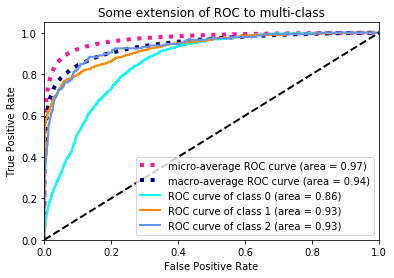

In [54]:
n_classes = len(tags_counts)
print(tags_counts.keys())
print(n_classes)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)
#ROC下的面积，AUC越大越好

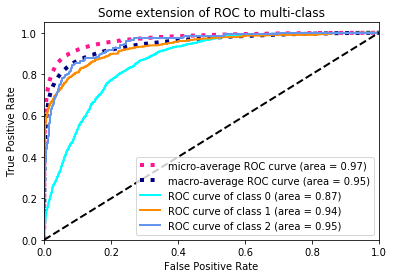

In [55]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

In [57]:
#前面的工作是为了选中模型，这部分工作是为了加入正则，利用验证集进行调参
#用f1作为评判指标，通过实验来训练分类器
#对比bow和tf-idf
#在logistic　Regression选择其中一个，加入l1和l2正则化
######################################
######### YOUR CODE HERE #############
######################################


#采用了词袋模型和tf-idf两种形式进行训练
num_list = [0.1, 1, 10, 100]
# score_list = []
# for num in num_list:
#     classifier_tfidf = train_classifier(X_train_tfidf, y_train, num)
#     y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)   #预测
#     #print("y_val_predicted_labels_tfidf", y_val_predicted_labels_tfidf)
# #     print(y_val_predicted_labels_tfidf.shape)   #(30000, 100) 表示每个样本对100个标签都有预测，看符合哪几个标签
# #     print(y_val.shape)
#     score = f1_score(y_val, y_val_predicted_labels_tfidf, average='weighted')
#     score_list.append(score)

# print("score_list", score_list)   #在预测数据中存在实际类别没有的标签时报此warning
# #取list中元素最大的f1值的下标
# index = score_list.index(max(score_list))
# #取出对应的num
# num = num_list[index]
num = num_list[2]
#获取模型
classifier_tfidf = train_classifier(X_train_tfidf, y_train, num)#此模型用于最后的测试


When you are happy with the quality, create predictions for *test* set, which you will submit to Coursera.

In [58]:
test_predictions =classifier_tfidf.predict(X_test_tfidf)     ######### YOUR CODE HERE #############
test_pred_inversed = mlb.inverse_transform(test_predictions)
print(test_pred_inversed)
test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

[('mysql', 'php'), ('html', 'javascript', 'jquery'), (), ('javascript', 'jquery'), ('android', 'java'), ('parsing', 'php', 'xml'), ('json', 'web-services'), ('java', 'swing'), ('file', 'python'), ('html',), ('jquery', 'sql'), ('r',), ('php',), ('ruby-on-rails',), ('c#',), ('python',), ('c++',), ('ajax', 'html', 'javascript', 'jquery', 'ruby-on-rails'), (), ('c', 'linux', 'sockets'), ('python',), ('pandas', 'python'), ('c++', 'multithreading'), ('c#',), ('php', 'wordpress'), ('c', 'c++'), ('ruby', 'ruby-on-rails', 'ruby-on-rails-3'), ('c#', 'wpf'), ('python',), ('r',), ('html', 'javascript', 'jquery'), ('c#',), ('html', 'javascript'), ('python',), ('hibernate', 'java', 'spring'), (), ('c#', 'wpf', 'xaml'), ('javascript',), ('php',), ('java',), ('java', 'sockets'), ('c#',), ('javascript', 'jquery'), ('eclipse', 'java'), ('c#',), ('php',), ('c#',), (), (), ('c++', 'eclipse'), ('javascript', 'jquery'), ('c#',), ('c++',), ('javascript',), ('google-maps', 'javascript'), (), ('python',), ('c#

### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [85]:
#查看在logistic模型中权重最大的特征（word 或者是 n_gram）

def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    estimator = classifier.estimators_
#     print("classifier.estimators_:\n", classifier.estimators_)
    coefficients = estimator[0].coef_   #拿到所有特征的系数
    print(len(coefficients[0]))
    my_coefficients_list = coefficients.tolist()
    #求最大参数的下标
    word_positive_index = my_coefficients_list.index(max(my_coefficients_list))
    #拿到对应下标的特征
    print("the most positive word: ", index_to_words[word_positive_index])
    #求最小参数的下标
    word_negative_index = my_coefficients_list.index(min(my_coefficients_list))
    #拿到对应下标的特征
    print("the most positive word: ", index_to_words[30])
    print(index_to_words.values())
#     print("params:\n", len(params[0]))
#     print("params:\n", params)
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    top_positive_words = ['a','a','a','a','a']# top-5 words sorted by the coefficiens.
    top_negative_words = ['a','a','a','a','a']# bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [86]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
# print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
# print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
17209
the most positive word:  #
the most positive word:  000
dict_values(['draw', 'stacked', 'r', 'mysql', 'select', 'records', 'datetime', 'field', 'specified', 'value', 'mysql select', 'select records', 'datetime field', 'terminate', 'windows', 'phone', '81', 'app', 'windows phone', 'phone 81', '81 app', 'current', 'time', 'specific', 'country', 'jquery', 'current time', 'time specific', 'configuring', 'tomcat', 'use', 'ssl', 'awesome', 'nested', 'set', 'plugin', 'add', 'new', 'children', 'tree', 'various', 'levels', 'add new', 'create', 'map', 'json', 'response', 'ruby', 'rails', '3', 'json response', 'ruby rails', 'rails 3', 'rspec', 'test', 'method', 'called', 'rspec test', 'test method', 'method called', 'springboot', 'lifecycle', 'exception', 'import', 'data', 'excel', 'database', 'using', 'php', 'import data', 'data excel', 'mysql database', 'database using', 'using php', 'obtaining', 'object', 'parameterized', 'type', 'constructing', 'class', 'ipad', 'selecting', 'text

### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [757]:
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	html,javascript,jquery
2	
3	javascript,jquery
4	android,java
5	parsing,php,xml
6	json,...


In [759]:
STUDENT_EMAIL = "1169256548@qq.com"# EMAIL 
STUDENT_TOKEN = "rGMNFoyDYzHdmJga"# TOKEN 
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	html,javascript,jquery
2	
3	javascript,jquery
4	android,java
5	parsing,php,xml
6	json,...


If you want to submit these answers, run cell below

In [760]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [ ]:
"""这个课的几个作业都需要花些时间，做完后面试的时候可以讲比较多的细节"""